### Valeria Rebagliati 4852454
#### dataset 12: movimenti


# Introduzione

Vengono forniti due dataset, il primo position che rappresenta i muovimenti e le cordinate degli spostamenti nel tempo, il secondo feature, che associa al primo varie feature per ogni azione; le feature danno informazioni sulle azioni dividendosi in tre macro-gruppi che sono: displacement, frequency, dynamic.
Per ogni azione svolta da un certo individuo (in totale 16 persone) vengono raccolti 2 video. Per tracciare l'azione vengono presi dei riferimenti nel corpo che chiameremo giunti e sono: occhi, naso, orecchie, spalle, gomiti e polsi.

# Obiettivi

Confronterò azioni simili rispetto alle loro proprietà cinematiche ovvero usando le propietà di:
- spostamento
- velocità
- accelerazione 
- derivate delle precedenti


Per quanto riguarda i gruppi di azioni abbiamo quindi:
* trasporto - tocco (di cubo di rubik e bottiglia)
* bere - mangiare patatine 
* lavarsi le mani - aprire una bottiglia - giocare con il cubo di rubik


In [1]:
import pandas as pd
import numpy as np
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import sklearn 


from sklearn import preprocessing
from sklearn.cluster import KMeans

import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn import decomposition


In [2]:
positions_3d = "positions_3d.csv"
features = "features.parquet.gz"

In [3]:
#versione di sklearn utilizzata
print(sklearn.__version__)
#%pip install -U scikit-learn

1.1.1


In [4]:
positions_df = pd.read_csv(positions_3d, header=[0, 1], index_col=[0, 1, 2, 3]).astype(np.float16)

### Esplorazione
Vediamo informazioni di base relative al dataset position

In [5]:
positions_df.head()

joint                              lear                 lelbow           \
variable                              x       y       z      x        y   
individual action   sample frame                                          
0          drinking 0      0      514.5 -355.50  2058.0  626.0  134.000   
                           1      515.0 -357.50  2060.0  626.0  134.000   
                           2      515.0 -357.50  2060.0  626.0  134.000   
                           3      515.0 -357.50  2060.0  626.0  134.000   
                           4      515.5 -359.75  2062.0  628.5  134.125   

joint                                       leye                 lshoulder  \
variable                               z       x       y       z         x   
individual action   sample frame                                             
0          drinking 0      0      1706.0  467.50 -369.00  2064.0     568.0   
                           1      1706.0  467.75 -371.00  2066.0     565.5   
                           2      1706.0  466.00 -373.25  2066.0     565.5   
                           3      1706.0  466.00 -373.25  2066.0     565.5   
                           4      1707.0  466.00 -373.25  2066.0     565.5   

joint                             ...  relbow    reye                  \
variable                          ...       z       x       y       z   
individual action   sample frame  ...                                   
0          drinking 0      0      ...  1678.0  366.50 -374.75  2070.0   
                           1      ...  1682.0  366.75 -377.00  2072.0   
                           2      ...  1682.0  366.75 -377.00  2072.0   
                           3      ...  1682.0  367.00 -379.25  2074.0   
                           4      ...  1682.0  367.00 -379.25  2074.0   

joint                            rshoulder                     rwrist          \
variable                                 x        y       z         x       y   
individual action   sample frame                                                
0          drinking 0      0       128.750 -72.9375  1891.0  42.84375  200.75   
                           1       128.875 -74.8750  1892.0  41.43750  200.00   
                           2       128.875 -74.8750  1892.0  41.43750  200.00   
                           3       128.875 -74.8750  1892.0  41.43750  200.00   
                           4       128.875 -74.8750  1892.0  41.43750  200.00   

joint                                     
variable                               z  
individual action   sample frame          
0          drinking 0      0      1469.0  
                           1      1473.0  
                           2      1473.0  
                           3      1473.0  
                           4      1473.0  

[5 rows x 33 columns]

In [6]:
positions_df.shape

(59941, 33)

In [7]:
positions_df.dtypes

joint      variable
lear       x           float16
           y           float16
           z           float16
lelbow     x           float16
           y           float16
           z           float16
leye       x           float16
           y           float16
           z           float16
lshoulder  x           float16
           y           float16
           z           float16
lwrist     x           float16
           y           float16
           z           float16
nose       x           float16
           y           float16
           z           float16
rear       x           float16
           y           float16
           z           float16
relbow     x           float16
           y           float16
           z           float16
reye       x           float16
           y           float16
           z           float16
rshoulder  x           float16
           y           float16
           z           float16
rwrist     x           float16
           y       

**Livelli del dataset**

In [8]:
for i in range(positions_df.index.nlevels):
    index = positions_df.index.get_level_values(i).unique()
    print(index.name, ":", index, "\n")

individual : Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='individual') 

action : Index(['drinking', 'eat_crisp', 'open_close_bottle', 'rubiks_cube', 'sanitise',
       'touch_bottle', 'touch_rubiks_cube', 'transport_bottle',
       'transport_pen', 'transport_rubiks_cube'],
      dtype='object', name='action') 

sample : Int64Index([0, 1, 2], dtype='int64', name='sample') 

frame : Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            459, 460, 461, 462, 463, 464, 465, 466, 467, 468],
           dtype='int64', name='frame', length=469) 



In [9]:
for i in range(positions_df.columns.nlevels):
    col = positions_df.columns.get_level_values(i).unique()
    print(col.name, ":", col, "\n")

joint : Index(['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear',
       'relbow', 'reye', 'rshoulder', 'rwrist'],
      dtype='object', name='joint') 

variable : Index(['x', 'y', 'z'], dtype='object', name='variable') 



### Visualizzazione
Per avere un punto di partenza nell'analisi dei dati parto con la visualizzazione dei movimenti, attingendo dal primo dataset fornito, **posistion**; in questo modo sarà possibile formulare delle ipotesi su cui costruire test successivi.

Per farlo ho costruito la funzione di seguito che, data un'azione, una lista di giunti e una persona restituirà il grafico del movimento dei giunti di quella persona mentre svolge quella determinata azione.
In questo modo potremmo visualizzare il muovimento nello spazio con la traiettoria dei vari giunti.

In [10]:
def plot_action(action, joints, pearson):
    
    fig = plt.figure()
 
    ax = plt.axes(projection ='3d')
    
    #rotazione di 180 rispetto a y e 180 rispetto a x
    ax.view_init(90,90)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    for i in range(0, len(joints)):
        
        z = positions_df.loc[idx[ pearson, action, 0, :], idx[joints[i], "z"]]
        x = positions_df.loc[idx[ pearson, action, 0, :], idx[joints[i], "x"]]
        y = positions_df.loc[idx[ pearson, action, 0, :], idx[joints[i], "y"]]

        ax.plot3D(x, y, z)

    plt.show()
    


Prima di vedere i grafici, posso fare delle supposizioni su quello che vedrò:
* i movimenti di tutte le componenti del viso per qualsiasi azione, saranno uguali ma con shift diversi, come i movimenti delle spalle, perchè stanno sullo stesso asse
* i movimenti presi dai giunti delle braccia saranno meno "rigidi" e indipendenti rispetto a quelli sopra
* le varie azioni di trasporto avranno movimenti simili
* le varie azioni di tocco avranno movimenti simili

Per completezza nella rappresentazione prenderò tutti i giunti per chiarire il movimento generale.

Parto con la visualizzazione di trasporto bottiglia e a seguire tocco bottiglia:

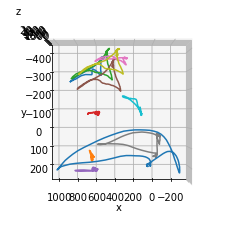

In [11]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear', 'relbow', 'reye', 'rshoulder', 'rwrist']

action = "transport_bottle"
plot_action(action,joints,0)

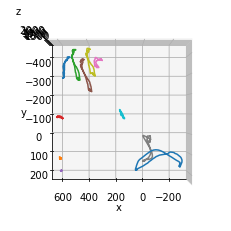

In [12]:
action = "touch_bottle"
plot_action(action, joints, 0)

Trasporto e tocco del cubo di rubik:

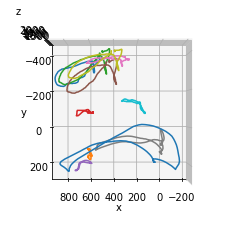

In [13]:
action = "transport_rubiks_cube"
plot_action(action,joints,0)

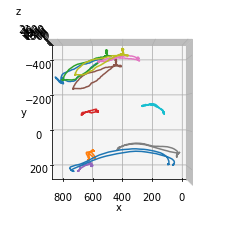

In [14]:
action = "touch_rubiks_cube"
plot_action(action, joints, 0)

Bere e mangiare patatine:

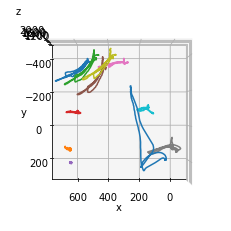

In [15]:
action = "drinking"
plot_action(action,joints,0)

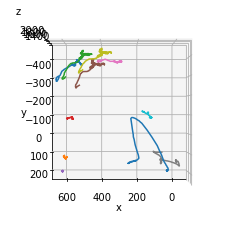

In [16]:
action = "eat_crisp"
plot_action(action,joints,0)

Laversi le mani, aprire e chiudere una bottiglia e giocare con il cubo di rubik:

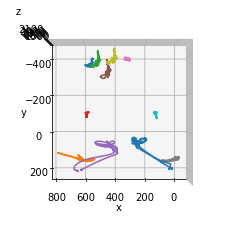

In [17]:
action = "sanitise"
plot_action(action,joints,0)

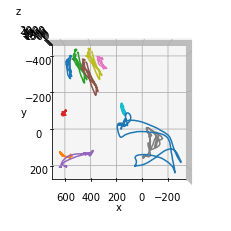

In [18]:
action = "open_close_bottle"
plot_action(action,joints,0)

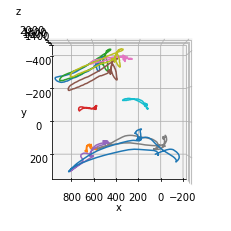

In [19]:
action = "rubiks_cube"
plot_action(action,joints,0)

Da una prima analisi visiva possiamo dire che come ci aspettavamo tutti i giunti del viso tracciano lo stesso disegno nello spazio. Stessa cosa per le spalle, anche se in generale, se la persona ruota la testa o le spalle verso destra o sinistra, la telecamera potrebbe non vedere più i giunti di riferimento e di conseguenza i dati potrebbero subire del rumore. 
I movimenti dei polsi non sono simmetrici fatta esclusione per l'azione di sanitise.

Notiamo subito che qualsiasi sia l'oggetto trasportato la traiettoria del movimento è molto simile per tutti i traporti, anche se varia l'ampiezza.
I muovimenti del viso seguono quello del braccio destro che trasporta l'oggetto.

Notiamo che le azioni di trasporto sono comprese nelle altre azioni, infatti prima di compiere l'azione vera e propria, l'individuo prende l'oggetto necessario per compiere l'azione, e questo provoca rumore nell' analisi del singolo movimento; questa cosa non si nota nell'azione di sanitise, probabilmente perchè l'individuo simula l'azione e non prende effettivamente il gel.

Infine notiamo che per l'individuo 0 il tocco e il trasporto della bottiglia non sono troppo simili, infatti la traiettoria del muovimento è simile ma nel tocco ha un'ampiezza minore; probabilmente questo dipende dalla posizione dell'oggetto sul tavolo rispetto all'individuo.
Per il tocco e il traporto del cubo di rubik per l'individuo 0 notiamo invece una somiglianza più forte, questo probabilmente è dovuto alla posizione dell'oggetto come detto precedentemente per la bottiglia.
Assumendo di prendere gli oggetti con la mano destra, se l'oggetto è alla propria destra il movimento sarà minimo, come forse è accaduto nel tocco della bottiglia, invece se è alla sinistra come forse è stato nel tocco del cubo di rubik il movimento totale è più simile al trasporto.

Le spalle fanno un movimento minimo come ci si poteva aspettare e i gomiti "seguono" il muovimento del relativo polso, quello destro traccia un muovimento simile ma meno ampio e quello sinistro fa movimenti impercettibili come il relativo polso.

# Features

units: meters and seconds

In [20]:
features_df = pd.read_parquet(features).applymap(lambda x: x.astype(np.float16))

### Esplorazione
Vediamo informazioni di base relative al dataset feature

In [21]:
features_df.head(1)

type_feature                                                       displacement  \
data                                                                  positions   
feature                                                        max_displacement   
variable                                                                      x   
joint person action   sample                                                      
lear  0      drinking 0       [0.015, 0.0205, 0.0285, 0.036, 0.044, 0.054, 0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      y   
joint person action   sample                                                      
lear  0      drinking 0       [0.02174, 0.02824, 0.03275, 0.03925, 0.04575, ...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      z   
joint person action   sample                                                      
lear  0      drinking 0       [0.014, 0.017, 0.019, 0.022, 0.024, 0.025, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                              magnitude   
joint person action   sample                                                      
lear  0      drinking 0       [0.0299, 0.03882, 0.0474, 0.05762, 0.0679, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                      total_displacement   
variable                                                                      x   
joint person action   sample                                                      
lear  0      drinking 0       [0.015, 0.02, 0.028, 0.0355, 0.043, 0.053, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      y   
joint person action   sample                                                      
lear  0      drinking 0       [0.01525, 0.02374, 0.02824, 0.03476, 0.0435, 0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      z   
joint person action   sample                                                      
lear  0      drinking 0       [-0.008, -0.013, -0.015, -0.018, -0.022, -0.02...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                              magnitude   
joint person action   sample                                                      
lear  0      drinking 0       [0.02284, 0.03366, 0.0425, 0.05283, 0.065, 0.0...   

type_fea

In [22]:
features_df.shape

(3520, 158)

In [23]:
features_df.dtypes

type_feature  data       feature             variable 
displacement  positions  max_displacement    x            object
                                             y            object
                                             z            object
                                             magnitude    object
                         total_displacement  x            object
                                                           ...  
dynamic       jerk       skewness            magnitude    object
                         kurtosis            x            object
                                             y            object
                                             z            object
                                             magnitude    object
Length: 158, dtype: object

In [24]:
type(features_df.iloc[0, 0])

numpy.ndarray

In [25]:
features_df.iloc[0, 0].dtype

dtype('float16')

**Livelli del dataset**

In [26]:
for i in range(features_df.index.nlevels):
    print(features_df.index.get_level_values(i).unique())

Index(['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear',
       'relbow', 'reye', 'rshoulder', 'rwrist'],
      dtype='object', name='joint')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='person')
Index(['drinking', 'eat_crisp', 'open_close_bottle', 'rubiks_cube', 'sanitise',
       'touch_bottle', 'touch_rubiks_cube', 'transport_bottle',
       'transport_pen', 'transport_rubiks_cube'],
      dtype='object', name='action')
Int64Index([0, 1, 2], dtype='int64', name='sample')


In [27]:
for i in range(features_df.columns.nlevels):
    print(features_df.columns.get_level_values(i).unique())

Index(['displacement', 'frequency', 'dynamic'], dtype='object', name='type_feature')
Index(['positions', 'velocities', 'acceleration', 'jerk'], dtype='object', name='data')
Index(['max_displacement', 'total_displacement', 'peak_power_density',
       'entropy_power_density', 'sum_power_density', 'maximum',
       'third_quartile', 'second_quartile', 'first_quartile', 'minimum', 'iqr',
       'ptp', 'mean', 'variance', 'standard_deviation', 'skewness',
       'kurtosis'],
      dtype='object', name='feature')
Index(['x', 'y', 'z', 'magnitude'], dtype='object', name='variable')


---

## Correlazione

Secondo le osservazioni fatte sopra provo a formulare le seguenti ipotesi che validerò o meno con il calcolo della correlazione:

* Ci aspettiamo una correlazione alta anche tra le azioni simili:
    - trasporto e tocco del cubo di rubik
    - trasporto e tocco bottiglia
    - bere e mangiare
    - sanitise e aprire bottiglia
    - sanitise e giocare con il cubo di rubik
    - aprire bottiglia e cubo di rubik

**Nota: calcolare correlazione solo con feature di cinematica non di frequenza, non ha senso, forse non hanno senso nemmeno displacement e dynamic**

1.1.: Correlazione tra trasporto e tocco del cubo di rubik 


<AxesSubplot:title={'center':'total displacement tocco cubo di rubik - polso destro'}>

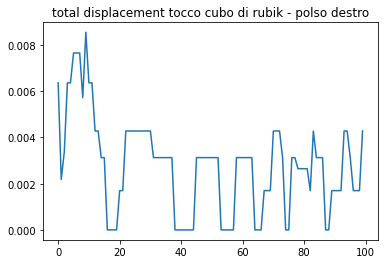

In [28]:
touch_rc_disp = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc_disp.plot(title="total displacement tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'total displacement trasporto cubo di rubik - polso destro'}>

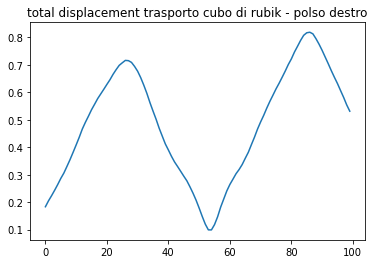

In [29]:
transport_rc_disp = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:100]

transport_rc_disp.plot(title="total displacement trasporto cubo di rubik - polso destro")

In [30]:
np.corrcoef(touch_rc_disp.astype(float),transport_rc_disp.astype(float))

array([[ 1.        , -0.01179343],
       [-0.01179343,  1.        ]])

Non c'è correlazione tra i total displacement dei polsi destri di trasporto e tocco del cubo di rubik

<AxesSubplot:title={'center':'velocità media tocco cubo di rubik - polso destro'}>

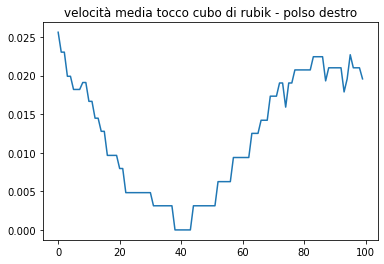

In [31]:
touch_rc_vel = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc_vel.plot(title="velocità media tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'velocità media trasporto cubo di rubik - polso destro'}>

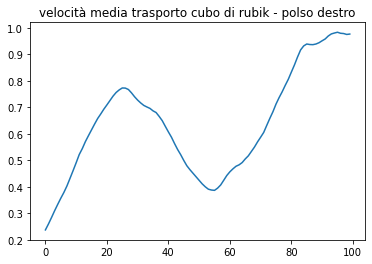

In [32]:
transport_rc_vel = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]

].explode().reset_index(drop=True)[:100]

transport_rc_vel.plot(title="velocità media trasporto cubo di rubik - polso destro")

In [33]:
np.corrcoef(touch_rc_vel.astype(float),transport_rc_vel.astype(float))

array([[1.       , 0.2893575],
       [0.2893575, 1.       ]])

Non c'è correlazione tra le due azioni sotto il punto di vista della velocità media

<AxesSubplot:title={'center':'accelerazione media tocco cubo di rubik - polso destro'}>

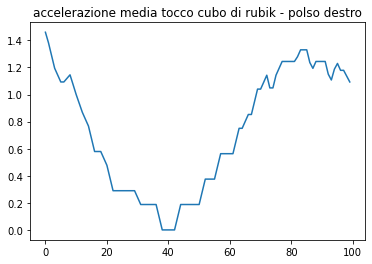

In [34]:
touch_rc_acc = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc_acc.plot(title="accelerazione media tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'accelerazione media trasporto cubo di rubik - polso destro'}>

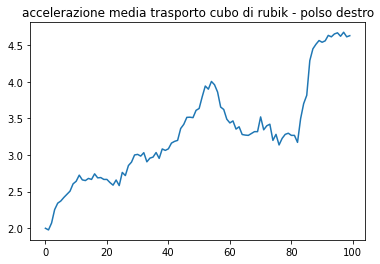

In [35]:
transport_rc_acc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]

].explode().reset_index(drop=True)[:100]

transport_rc_acc.plot(title="accelerazione media trasporto cubo di rubik - polso destro")

In [36]:
np.corrcoef(touch_rc_acc.astype(float),transport_rc_acc.astype(float))

array([[1.        , 0.19946077],
       [0.19946077, 1.        ]])

Non c'è correlazione tra le due azioni sotto il punto di vista dell' accelerazione media

<AxesSubplot:title={'center':'accelerazione media tocco cubo di rubik - polso destro'}>

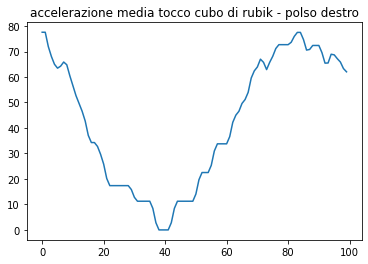

In [37]:
touch_rc_j = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["dynamic", "jerk", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc_j.plot(title="accelerazione media tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'accelerazione media trasporto cubo di rubik - polso destro'}>

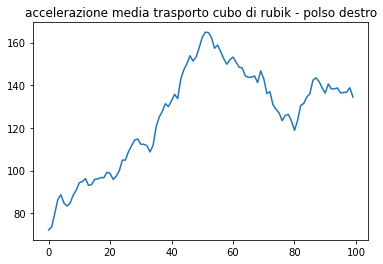

In [38]:
transport_rc_j = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["dynamic", "jerk", "mean", "magnitude"]

].explode().reset_index(drop=True)[:100]

transport_rc_j.plot(title="accelerazione media trasporto cubo di rubik - polso destro")

In [39]:
np.corrcoef(touch_rc_j.astype(float),transport_rc_j.astype(float))

array([[ 1.        , -0.14990019],
       [-0.14990019,  1.        ]])

Non ci sono correlazioni tra i jerk delle due azioni

In generale le due azioni non sono correlate sotto il punto di vista di spostamento e dinamica.

**TODO**: FARE STESSA ANALISI PER LE ALTRE COPPIE DI AZIONI SIMIILI (forse, ha senso?)

---

## T-Test

Come abbiamo visto dai grafici dei movimenti, quelli di trasporto e quelli di tocco del cubo di rubik sono molto simili, possiamo fare un test statistico per confermare l'ipotesi. Quindi avremo:

* H0 = l'azione di trasporto è simile a quella di tocco
* HA = l'azione di trasporto è diversa da quella di tocco

Usiamo il t-test per valutare le due ipotesi; in particolare valutiamo le due azioni rispetto alle feature legate al displacement.


Per fare il t-test è necessario prendere un campione rispetto alla popolazione totale, e devono valere le seguenti regole:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.

Inoltre prenderemo come soglie:
* Livello di siginificatività : 0.05
* Livello di confidenza: 95%


Calcolo la popolazione totale

In [40]:
transport_rc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

transport_rc.shape

(3905,)

In [41]:
touch_rc = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

touch_rc.shape

(3104,)

In [42]:
total_pop = pd.Series
total_pop = pd.concat([touch_rc,transport_rc])
total_pop.shape

(7009,)

Quindi in questo caso abbiamo che:
1. n = 310 > 30
2. N è circa 3100

Seleziono il campione dal trasporto del cubo di rubik

In [43]:
a_touch_rc = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[1800:1800+700]

a_touch_rc.shape

(700,)

In [44]:
t_statistic, p_value = stats.ttest_1samp(a= a_touch_rc, popmean=transport_rc.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  0.19450241353806638
p-value:  0.84583902056506


Dato che il p-value è maggiore del livello di significatività **non posso rigettare l'ipotesi nulla**, potremmo accettare l'ipotesi nulla se il p-value fosse >0.95.
Quindi c'è buona probabilità che le due azioni siano simili.

---

* H0 = l'azione di trasporto bottiglia è simile a quella di tocco bottiglia
* HA = l'azione di trasporto bottiglia è diversa da quella di tocco bottiglia


Calcolo la popolazione totale

In [45]:
transport_bot = features_df.loc[
    idx["rwrist", :, "transport_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

transport_bot.shape

(4342,)

In [46]:
touch_bot = features_df.loc[
    idx["rwrist", :, "touch_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

touch_bot.shape

(2714,)

In [47]:
total_pop = pd.Series
total_pop = pd.concat([touch_bot,transport_bot])
total_pop.shape

(7056,)

Quindi in questo caso abbiamo che:
1. n = 700 > 30
2. N è circa 7000

Seleziono il campione dal trasporto della bottiglia

In [48]:
a_touch_bot = features_df.loc[
    idx["rwrist", :, "touch_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[1200:1200+700]

a_touch_bot.shape

(700,)

In [49]:
t_statistic, p_value = stats.ttest_1samp(a=a_touch_bot, popmean=transport_bot.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  -40.618642374508234
p-value:  3.848416600235509e-186


Dato che il p-value è minore del livello di significatività quindi **rigetto l'ipotesi nulla in favore di quella alternativa**; le due azioni sono diverse.

---

* H0 = l'azione di sanitise è simile a quella di giocare con il cubo di rubik
* HA = l'azione di sanitise è diversa da quella di giocare con il cubo di rubik


Calcolo la popolazione totale


In [50]:
sanitise = features_df.loc[
    idx["rwrist", :, "sanitise", :],
    idx['dynamic', 'velocities', 'mean', 'magnitude']
].explode().reset_index(drop=True)

sanitise.shape

(5372,)

In [51]:
rc = features_df.loc[
    idx["rwrist", :, "rubiks_cube", :],
    idx['dynamic', 'velocities', 'mean', 'magnitude']
].explode().reset_index(drop=True)

rc.shape

(8373,)

In [52]:
total_pop = pd.Series
total_pop = pd.concat([rc,sanitise])
total_pop.shape

(13745,)

Quindi in questo caso abbiamo che:
1. n = 1300 > 30
2. N è circa 13000

Seleziono il campione da sanitise

In [53]:
a_sanitise = features_df.loc[
    idx["rwrist", :, "sanitise", :],
    idx['dynamic', 'velocities', 'mean', 'magnitude']
].explode().reset_index(drop=True)[900:900+1300]

a_sanitise.shape

(1300,)

In [54]:
t_statistic, p_value = stats.ttest_1samp(a=a_sanitise, popmean=rc.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  -0.047162097847846245
p-value:  0.9623912848580733


Dato che il p-value è maggiore del livello di confidenza **accetto l'ipotesi nulla**:
le azioni di lavarsi le mani e giocare con il cubo di rubik sono simili.

---

* H0 = l'azione di sanitise è simile a quella di aprire e chiudere la bottiglia
* HA = l'azione di sanitise è diversa da quella di aprire e chiudere la bottiglia


Calcolo la popolazione totale


In [55]:
ocb = features_df.loc[
    idx["rwrist", :, "open_close_bottle", :],
    idx['dynamic', 'velocities', 'mean', 'magnitude']
].explode().reset_index(drop=True)

ocb.shape

(8691,)

In [56]:
total_pop = pd.Series
total_pop = pd.concat([sanitise,ocb])
total_pop.shape


(14063,)

Quindi in questo caso abbiamo che:
1. n = 1400 > 30
2. N è circa 14000

In [57]:
a_ocb = features_df.loc[
    idx["rwrist", :, "open_close_bottle", :],
    idx['dynamic', 'velocities', 'mean', 'magnitude']
].explode().reset_index(drop=True)[3300:3300+1400]

a_ocb.shape

(1400,)

In [58]:
t_statistic, p_value = stats.ttest_1samp(a= a_sanitise, popmean= ocb.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  -22.850558180755478
p-value:  2.043662607028463e-97


Dato che il p-value è minore del livello di significatività **rigetto l'ipotesi nulla in favore di quella alternativa**; le due azioni sono diverse.

---

* H0 = l'azione di giocare con il cubo di rubik è simile a quella di aprire e chiudere la bottiglia
* HA = l'azione di giocare con il cubo di rubik è diversa da quella di aprire e chiudere la bottiglia


Calcolo la popolazione totale


In [59]:
total_pop = pd.Series
total_pop = pd.concat([rc,ocb])
total_pop.shape

(17064,)

Abbiamo già calcolato le varie popolazioni totali quindi abbiamo che:
1. n = 1700 > 30
2. N è circa 17000

Seleziono il campione da rubiks_cube

In [60]:
a_rc = features_df.loc[
    idx["rwrist", :, "rubiks_cube", :],
    idx['dynamic', 'velocities', 'mean', 'magnitude']
].explode().reset_index(drop=True)[3200:3200+1700]

a_rc.shape

(1700,)

In [61]:
t_statistic, p_value = stats.ttest_1samp(a=a_rc, popmean=ocb.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  0.3650037167524639
p-value:  0.7151540610635017


Il p-value è maggiore del livello di significatività quindi **non possiamo rigettare l'ipotesi nulla**, la potremmo accettare se p-value>livello di confidenza. Le due azioni sono con buona probabilità simili

---

* H0 = l'azione di mangiare patatine è simile a quella di bere
* HA = l'azione di mangiare è diversa da quella di bere

Calcolo la popolazione totale


In [62]:
ec = features_df.loc[
    idx["rwrist", :, "eat_crisp", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

ec.shape

(4453,)

In [63]:
d = features_df.loc[
    idx["rwrist", :, "drinking", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

d.shape

(5996,)

In [64]:
total_pop = pd.Series
total_pop = pd.concat([ec,d])
total_pop.shape

(10449,)

Quindi in questo caso abbiamo che:
1. n = 1000 > 30
2. N è circa 10000

Seleziono il campione da mangiare patatine

In [65]:
a_ec = features_df.loc[
    idx["rwrist", :, "eat_crisp", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[2200:2200+1000]

a_ec.shape

(1000,)

In [66]:
t_statistic, p_value = stats.ttest_1samp(a= a_ec, popmean= d.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  -0.3979355026048134
p-value:  0.6907627490564527


Il p-value è maggiore del livello di significatività, **non posso rigettare l'ipotesi nulla**, le due azioni sono probabilmente simili.

###### NOTA: ho preso in considerazione la parte "centrale" dell'azione per fare in modo di confrontare la parte più significativa;i in un primo momento, provando con la parte iniziale del movimento, i risultati erano completamente diversi, infatti nessuno dei movimenti risultava simile.

---

## Regressione Logistica - ML supervisionato

Possiamo usare un algoritmo di regressione logistica per classificare se un'azione è relativa al trasporto o al tocco del cubo di rubik

Passi da seguire:

1. Dividere dataset in training e test;
2. Istanziare un oggetto della classe LogisticRegression;
3. Fare fit su training set;
4. Usare la funzione score che fornisce l'accuratezza intesa come numero di volte in cui abbiamo predetto correttamente la classe rispetto al totale. 

In [67]:
# funzione che divide il data set in train e test

def my_train_test_slipt(X, joints, actions):
    n_features = X.columns.size
    n_joints = len(joints)
    n_people = 16
    n_actions = len(actions)
    n_samples = 30

    tr = np.asarray(X.loc[idx[joints, :, actions, 0]].reset_index(drop=True))
    te = np.asarray(X.loc[idx[joints, :, actions, 1]].reset_index(drop=True))
    y_train = np.asarray(X.loc[idx[joints, :, actions, 0]].reset_index()['action'])
    y_test = np.asarray(X.loc[idx[joints, :, actions, 1]].reset_index()['action'])

    y_train_fixed = np.zeros(shape=(n_samples * n_people * n_actions), dtype=(np.unicode_, 16))
    y_test_fixed = np.zeros(shape=(n_samples * n_people * n_actions), dtype=(np.unicode_, 16))
    X_train = np.zeros((n_people * n_actions, n_features * n_joints, n_samples), dtype=np.float64)
    X_test = np.zeros((n_people * n_actions, n_features * n_joints, n_samples), dtype=np.float64)

    for z in range(n_people * n_actions):
        for k in range(n_joints):
            for j in range(n_features):
                for i in range(n_samples):
                    X_train[z, j + (n_joints - 1), i] = tr[z + k * (n_joints - 1)][j][-i]
        for i in range(n_samples):
            y_train_fixed[z * n_samples + i] = y_train[z]

    for z in range(n_people * n_actions):
        for k in range(n_joints):
            for j in range(n_features):
                for i in range(n_samples):
                    X_test[z, j + (n_joints - 1), i] = te[z + k * (n_joints - 1)][j][-i]
        for i in range(n_samples):
            y_test_fixed[z * n_samples + i] = y_test[z]

    X_train = X_train.reshape(-1, n_features * n_joints)
    X_test = X_test.reshape(-1, n_features * n_joints)

    if np.where(y_train_fixed == ''):
        return X_train, X_test, y_train_fixed, y_test_fixed
    else : 
        print("Ci sono degli elementi nulli")

In [68]:
joints = ['rwrist']

actions = ['transport_bottle', 'touch_bottle']

X = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

X_train,X_test,y_train_fixed,y_test_fixed = my_train_test_slipt(X, joints, actions)

In [69]:
regressor = LogisticRegression()

regressor.fit(X_train,y_train_fixed)
regressor.score(X_test,y_test_fixed)


0.6208333333333333

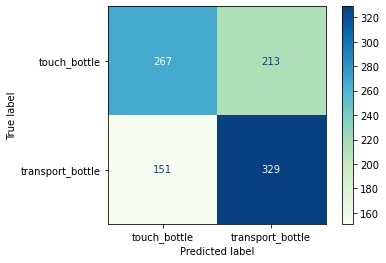

In [70]:
ConfusionMatrixDisplay.from_estimator(regressor, X_test, y_test_fixed, cmap='GnBu')

Possiamo dire che la clusterizzazione sia avvenuta con successo, il regressor score non è altissimo ma dalla matrice di confusione si vede che la maggior parte delle azioni è stata classificata correttamente. Il risulato era auspicabile in quanto dal ttest fatto in precedenza risulta che le due azioni sono diverse.


Calcolo la regressione logistica prendendo tutti i joints e tutte le feature della categoria displacement, del trasporto e tocco cubo di rubik.

In [71]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear','relbow', 'reye', 'rshoulder', 'rwrist']

actions = ['transport_rubiks_cube', 'touch_rubiks_cube']

X = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

X_train,X_test,y_train_fixed,y_test_fixed = my_train_test_slipt(X, joints, actions)

In [72]:
regressor = LogisticRegression()

regressor.fit(X_train,y_train_fixed)
regressor.score(X_test,y_test_fixed)


0.50625

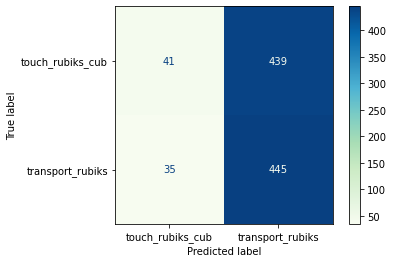

In [73]:
ConfusionMatrixDisplay.from_estimator(regressor, X_test, y_test_fixed, cmap='GnBu')

Il risultato che abbiamo ottenuto dalla regressione logistica di trasporto e tocco del cubo di rubik non è soddisfacente, ma era prevedibile in quanto dal ttest fatto in precedenza risultava che le due azioni sono simili, quindi è normale che l'algoritmo non riesca a classificarle correttamente.

Se avessimo classificato le azioni in modo casuale avremmo ottenuto un regressor score simile che si aggira intorno allo 0.5 come nel nostro caso.

La confusion matrix ha sulla sua diagonale i valori classificati correttamente, quindi avremmo ottenuto un risultato ottimale se la diagonale fosse stata blu scuro (tanti valori sarebbero stati classificati correttamente); invece osservando la matrice emerge che molte delle tuple associate all'azione di trasport sono state classificate correttamente, ma la maggior parte delle tuple relative al tocco sono state classificate erroneamente.

Usiamo ora un algoritmo di regressione logistica per classificare se un movimento fa parte delle azioni di: aprire e chiudere bottiglia, giocare con il cubo di rubik e lavarsi le mani

Considero tutti i joint e le feature di max_displacement sulla magnitude

In [74]:
joints = ['rwrist']
actions = ['sanitise', 'open_close_bottle']

X = features_df.loc[idx[joints, :, actions, :],idx[['dynamic'], ['velocities']]]

X_train,X_test,y_train_fixed,y_test_fixed = my_train_test_slipt(X, joints, actions)

In [75]:
regressor = LogisticRegression()

regressor.fit(X_train,y_train_fixed)
regressor.score(X_test,y_test_fixed)


/home/vale/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.678125

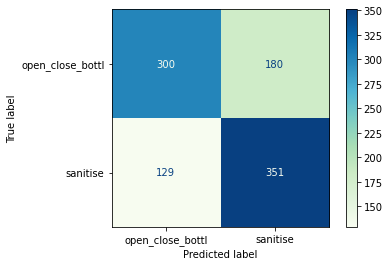

In [76]:
ConfusionMatrixDisplay.from_estimator(regressor, X_test, y_test_fixed, cmap='GnBu')

Clusterizzando in base a aprire e chiudere bottiglia e lavarsi le mani, otteniamo ottimi risultati infatti le due classi di azioni vengono ben riconosciuti in quanto anche secondo il ttest fatto in precedenza le due azioni sono diverse, provando a classificarle tutte e tre insieme otteniamo risultati ben differenti, di seguito prendo tutti i joints per tutte e tre le azioni:


In [77]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear','relbow', 'reye', 'rshoulder', 'rwrist']

actions = ['sanitise', 'open_close_bottle', 'rubiks_cube']

X = features_df.loc[idx[joints, :, actions, :],idx[['dynamic'], ['velocities']]]

X_train,X_test,y_train_fixed,y_test_fixed = my_train_test_slipt(X, joints, actions)

In [78]:
regressor = LogisticRegression()

regressor.fit(X_train,y_train_fixed)
regressor.score(X_test,y_test_fixed)

0.3715277777777778

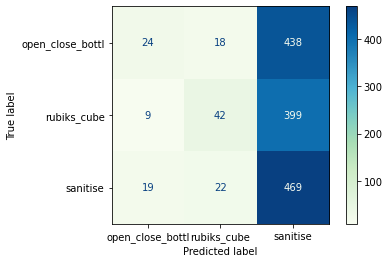

In [79]:
ConfusionMatrixDisplay.from_estimator(regressor, X_test, y_test_fixed, cmap='GnBu')

In questo caso l'algoritmo non riesce a classificare le azioni in modo corretto e si ottiene quasi una distribuzione casuale, infatti il regression score si aggira intorno allo 0.3

---

Sotto provo a classificare in base alle azioni di bere e mangiare patatine, prendo in considerazione come unico joints il naso, perchè è l'unico elemento che viene mosso in modo differente per le due azioni, infatti quando si beve si solleva il naso e quando si mangia, tendenzialmente no; uso le feature di displacement

In [80]:
joints = [ 'nose' ]
actions = ['drinking', 'eat_crisp']

X = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

X_train,X_test,y_train_fixed,y_test_fixed = my_train_test_slipt(X, joints, actions)

In [81]:
regressor = LogisticRegression()

regressor.fit(X_train,y_train_fixed)
regressor.score(X_test,y_test_fixed)


0.621875

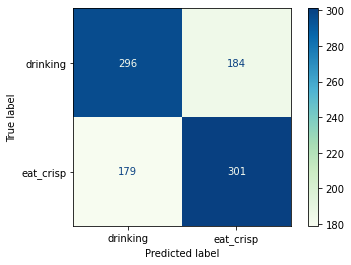

In [82]:
ConfusionMatrixDisplay.from_estimator(regressor, X_test, y_test_fixed, cmap='GnBu')

Il regressor score non è altissimo ma vediamo dalla matrice di confusione che nella maggior parte dei casi le azioni vengono classificate correttamente, quindi la differenza trovata è significativa.

---

In tutti i casi appena studiati, abbiamo sempre confermato i risultati ottenuti dai ttest, quando il ttest aveva esito "positivo" ovvero le due azioni erano simiili è stato difficile classificare le azioni in questione, al contrario quando le azioni risultavanon distinte dal ttest. Ci sono casi in cui ho considerato feature e joint diversi tra ttest e logistic regression quindi i risultati sono indipendenti

## KMeans - ML non supervisionato 

Ora provo a clusterizzare il dataset con kmeans dividendolo nelle due azioni di trasporto e tocco del cubo di rubik; in questo modo posso osservare la differenza tra approccio supervisionato e non.

Considero tutti i joints e tutte le feature della categoria displacement come fatto per la regressione logistica

In [83]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear','relbow', 'reye', 'rshoulder', 'rwrist']

actions = ['transport_rubiks_cube', 'touch_rubiks_cube']

X1 = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

n_features = X1.columns.size
n_joints = len(joints)
n_people = 16
n_actions = len(actions)
n_samples = 50


l = np.asarray(X1.loc[idx[joints, :, actions]].reset_index(drop=True))

X1 = np.zeros((n_people * n_actions * n_joints, n_features, n_samples), dtype=np.float64)

for z in range(len(X1)):
    for j in range(len(l[z])):
        for i in range(n_samples):
            X1[z, j, i] = l[z][j][i]
            
         
X1 = X1.reshape(-1, n_features)

scaler = preprocessing.StandardScaler().fit(X1)

X1 = scaler.transform(X1)



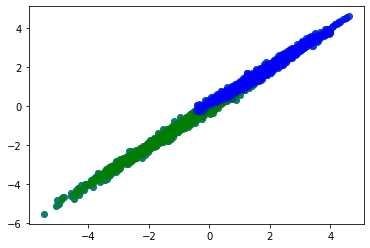

In [84]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X1)
y = kmeans.labels_
plt.scatter(X1[:,0],X1[:,1])
color = ['g','b']

for i in range(0,2):
    plt.scatter(X1[np.where(y==i),0],X1[np.where(y==i),1],color=color[i],alpha=0.3)


Per visualizzare meglio quanto ottenuto uso PCA

In [85]:
pca = decomposition.PCA(n_components=2)

In [86]:
X_pca = pca.fit_transform(X1)
print(X_pca.shape)


(17600, 2)


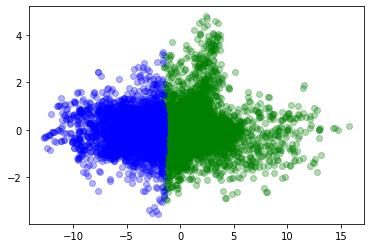

In [87]:
for i in range(0,2):
    plt.scatter(X_pca[np.where(y==i),0],X_pca[np.where(y==i),1],color=color[i],alpha=0.3)

Per capire la correttezza misuriamo l'indice di silhouette

In [88]:
from sklearn.metrics import silhouette_samples, silhouette_score
def silhouette(x):
    silhouette_avg = []
    for i in range(2, 16):
        kmeans = KMeans(n_clusters = i, max_iter = 20, random_state = 0)
        cluster_labels = kmeans.fit_predict(x)
        silhouette_avg.append(silhouette_score(x, cluster_labels))
    
    plt.plot(range(2, 16), silhouette_avg,'-o')
    plt.title('The silhouette method')
    plt.xlabel('Number of clusters')
    plt.ylabel('silhouette coefficient') #within cluster sum of squares
    plt.show()

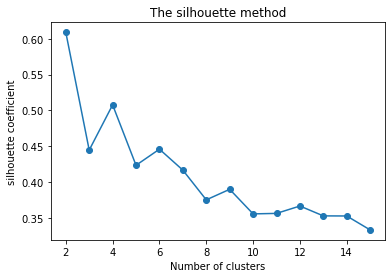

In [89]:
silhouette(X1)

Dal grafico risulta che il miglior indice di silhouette ottenibile è dividendo in due cluster.

**TODO: ripetere test per le altre coppie di azioni simili**



In [90]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear','relbow', 'reye', 'rshoulder', 'rwrist']

actions = ['transport_bottle', 'touch_bottle']

X1 = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

n_features = X1.columns.size
n_joints = len(joints)
n_people = 16
n_actions = len(actions)
n_samples = 45


l = np.asarray(X1.loc[idx[joints, :, actions]].reset_index(drop=True))

X1 = np.zeros((n_people * n_actions * n_joints, n_features, n_samples), dtype=np.float64)

for z in range(len(X1)):
    for j in range(len(l[z])):
        for i in range(n_samples):
            X1[z, j, i] = l[z][j][i]
            
         
X1 = X1.reshape(-1, n_features)

scaler = preprocessing.StandardScaler().fit(X1)

X1 = scaler.transform(X1)



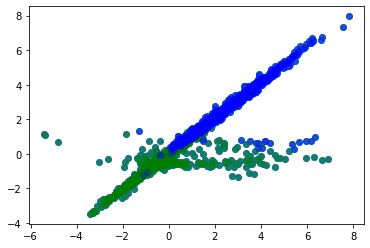

In [91]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X1)
y = kmeans.labels_
plt.scatter(X1[:,0],X1[:,1])
color = ['g','b']

for i in range(0,2):
    plt.scatter(X1[np.where(y==i),0],X1[np.where(y==i),1],color=color[i],alpha=0.3)


(15840, 2)


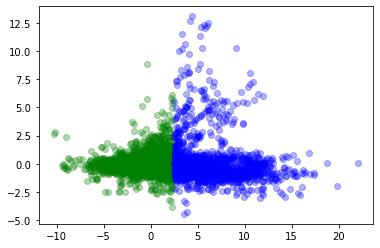

In [92]:
pca = decomposition.PCA(n_components=2)

X_pca = pca.fit_transform(X1)
print(X_pca.shape)

for i in range(0,2):
    plt.scatter(X_pca[np.where(y==i),0],X_pca[np.where(y==i),1],color=color[i],alpha=0.3)

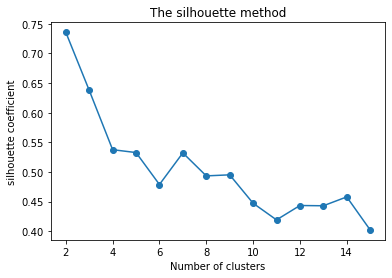

In [93]:
silhouette(X1)

In [94]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear','relbow', 'reye', 'rshoulder', 'rwrist']

actions = ['open_close_bottle', 'rubiks_cube', 'sanitise']

X1 = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

n_features = X1.columns.size
n_joints = len(joints)
n_people = 16
n_actions = len(actions)
n_samples = 45


l = np.asarray(X1.loc[idx[joints, :, actions]].reset_index(drop=True))

X1 = np.zeros((n_people * n_actions * n_joints, n_features, n_samples), dtype=np.float64)

for z in range(len(X1)):
    for j in range(len(l[z])):
        for i in range(n_samples):
            X1[z, j, i] = l[z][j][i]
            
         
X1 = X1.reshape(-1, n_features)

scaler = preprocessing.StandardScaler().fit(X1)

X1 = scaler.transform(X1)



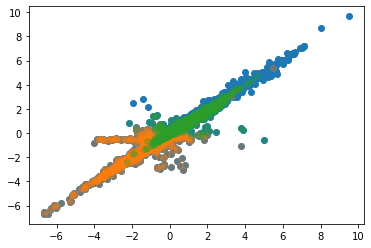

In [95]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X1)
y = kmeans.labels_
plt.scatter(X1[:,0],X1[:,1])
color = ['g','b']

for i in range(0,2):
    plt.scatter(X1[np.where(y==i),0],X1[np.where(y==i),1],alpha=0.3)

(23760, 2)


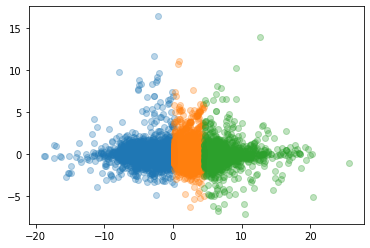

In [96]:
pca = decomposition.PCA(n_components=2)

X_pca = pca.fit_transform(X1)
print(X_pca.shape)

for i in range(0,3):
    plt.scatter(X_pca[np.where(y==i),0],X_pca[np.where(y==i),1],alpha=0.3)

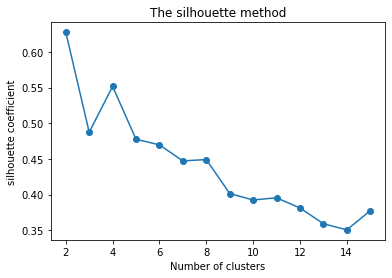

In [97]:
silhouette(X1)

In [98]:
joints = ['nose']

actions = ['eat_crisp', 'drinking']

X1 = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

n_features = X1.columns.size
n_joints = len(joints)
n_people = 16
n_actions = len(actions)
n_samples = 45


l = np.asarray(X1.loc[idx[joints, :, actions]].reset_index(drop=True))

X1 = np.zeros((n_people * n_actions * n_joints, n_features, n_samples), dtype=np.float64)

for z in range(len(X1)):
    for j in range(len(l[z])):
        for i in range(n_samples):
            X1[z, j, i] = l[z][j][i]
            
         
X1 = X1.reshape(-1, n_features)

scaler = preprocessing.StandardScaler().fit(X1)

X1 = scaler.transform(X1)


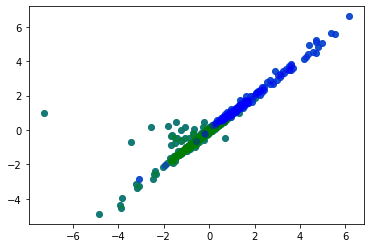

In [99]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X1)
y = kmeans.labels_
plt.scatter(X1[:,0],X1[:,1])
color = ['g','b']

for i in range(0,2):
    plt.scatter(X1[np.where(y==i),0],X1[np.where(y==i),1],color=color[i],alpha=0.3)


(1440, 2)


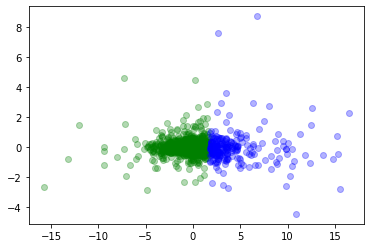

In [100]:
pca = decomposition.PCA(n_components=2)

X_pca = pca.fit_transform(X1)
print(X_pca.shape)

for i in range(0,2):
    plt.scatter(X_pca[np.where(y==i),0],X_pca[np.where(y==i),1],color=color[i],alpha=0.3)

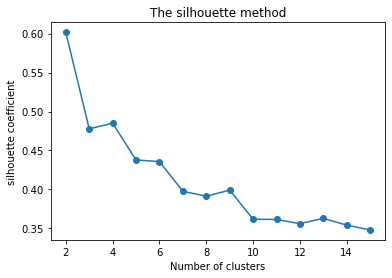

In [101]:
silhouette(X1)

La clusterizzazione con kmeans porta risultati simili a quella con la regressione logistica.

---

# Analisi della distribuzione della velocità

Di seguito i grafici dell'andamento e relativa distribuzione della velocità media delle varie azioni messi a confronto.

Tocco e trasporto del cubo di rubik del polso destro

(439,)


<AxesSubplot:>

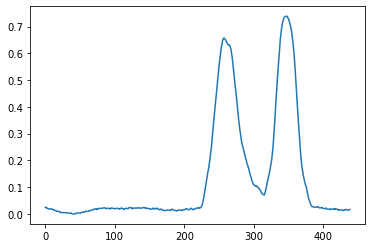

In [102]:
touch_rc = features_df.loc[
    idx["rwrist", 0, "touch_rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)

print(touch_rc.shape)

touch_rc.plot()

La prima parte in cui il grafico è piatto corrisponde probabilmente a un momento morto in cui l'individuo non fa nulla, appena inizia il movimento si vede un picco che probabilmente corrisponde al raggiungimento dell'oggetto, un 'avvallamento che corrisponde al momento del tocco vero e proprio dell'oggetto e l'ultimo picco che corrisponde con il movimento opposto che va dall'oggetto alla posizione di partenza.

<BarContainer object of 10 artists>

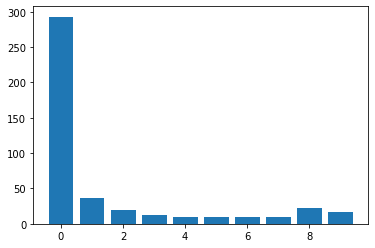

In [103]:
histo = np.histogram(features_df.loc[
    idx["rwrist", 0, "touch_rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True),bins=10)
plt.bar(x=np.asarray(range(10)),height=histo[0])

La colonna più alta è in corrispondenza dello zero proprio a causa dei vari momenti di non movimento.

(168,)


<AxesSubplot:>

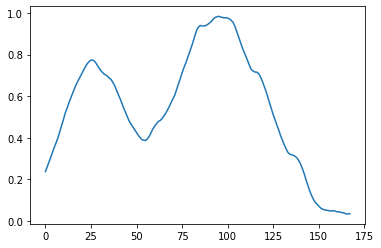

In [104]:
transport_rc = features_df.loc[
    idx["rwrist", 0, "transport_rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)

print(transport_rc.shape)

transport_rc.plot()

In questo caso l'individuo inizia subito l'azione come nel caso precedente ci sono due picchi, dall'inizio al primo picco abbiamo il raggiungimento dell'oggetto, il primo avvallamento corrisponde allo spostamento dell'oggetto, e infine dal picco alla fine si torna alla posizione di partenza. 

<BarContainer object of 10 artists>

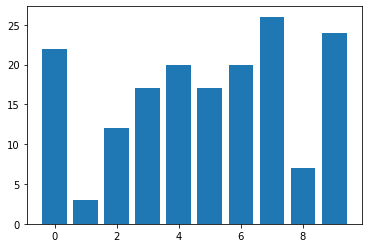

In [105]:
histo = np.histogram(features_df.loc[
    idx["rwrist", 0, "transport_rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True),bins=10)
plt.bar(x=np.asarray(range(10)),height=histo[0])

Gli istogrammi risultano diversi perchè si ha una scala diversa, proviamo ora a prendere dal primo grafico solo la parte significativa e a rifare gli istogrammi normalizzandoli.

(168,)


<AxesSubplot:>

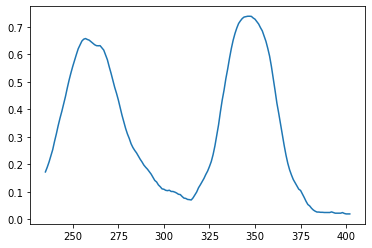

In [106]:
touch_rc = features_df.loc[
    idx["rwrist", 0, "touch_rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[235:235+168]

print(touch_rc.shape)

touch_rc.plot()

Gli andamenti dei due movimenti sono più simili, anche se hanno ampiezze diverse.

I due istogrammi normalizzati:

<BarContainer object of 10 artists>

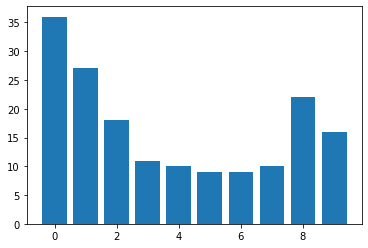

In [107]:
histo = np.histogram(features_df.loc[
    idx["rwrist", 0, "touch_rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[235:235+168]/168, bins=10)

plt.bar(x=np.asarray(range(10)),height=histo[0])

<BarContainer object of 10 artists>

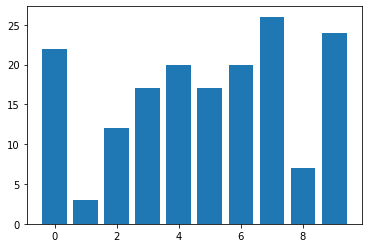

In [108]:
histo = np.histogram(features_df.loc[
    idx["rwrist", 0, "transport_rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)/168, bins=10)

plt.bar(x=np.asarray(range(10)),height=histo[0])

Le distribuzioni sono diverse nonostante i grafici abbiano andamenti simili.

In [109]:
"""
transport_rc = features_df.loc[
    idx["rwrist", 0, "transport_rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True).value_counts(bins= 11, normalize=True)
transport_rc.plot(kind='bar')
plt.figure()
touch_rc = features_df.loc[
    idx["rwrist", 0, "touch_rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True).value_counts(bins=11,normalize=True)
touch_rc.plot(kind='bar')
"""

'\ntransport_rc = features_df.loc[\n    idx["rwrist", 0, "transport_rubiks_cube", [0], :],\n    idx["dynamic", "velocities", "mean", "magnitude"]\n].explode().reset_index(drop=True).value_counts(bins= 11, normalize=True)\ntransport_rc.plot(kind=\'bar\')\nplt.figure()\ntouch_rc = features_df.loc[\n    idx["rwrist", 0, "touch_rubiks_cube", [0], :],\n    idx["dynamic", "velocities", "mean", "magnitude"]\n].explode().reset_index(drop=True).value_counts(bins=11,normalize=True)\ntouch_rc.plot(kind=\'bar\')\n'

(146,)


<AxesSubplot:>

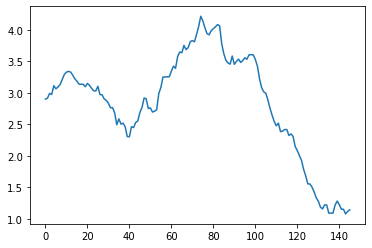

In [110]:
touch_rc = features_df.loc[
    idx["rwrist", 0, "touch_bottle", [0], :],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)

print(touch_rc.shape)

touch_rc.plot()

<BarContainer object of 10 artists>

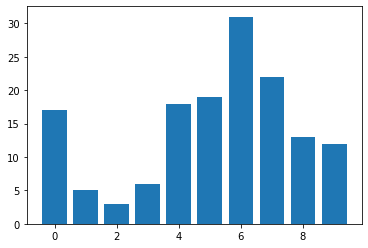

In [111]:
histo = np.histogram(features_df.loc[
    idx["rwrist", 0, "touch_bottle", [0], :],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)/146,bins=10)
plt.bar(x=np.asarray(range(10)),height=histo[0])

(146,)


<AxesSubplot:>

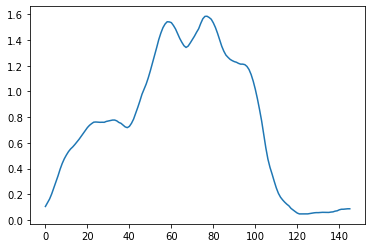

In [112]:
touch_rc = features_df.loc[
    idx["rwrist", 0, "transport_bottle", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:146]

print(touch_rc.shape)

touch_rc.plot()

<BarContainer object of 10 artists>

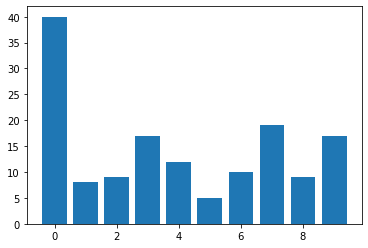

In [113]:
histo = np.histogram(features_df.loc[
    idx["rwrist", 0, "transport_bottle", [0], :],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:146]/146,bins=10)
plt.bar(x=np.asarray(range(10)),height=histo[0])

La distribuzione delle due azioni è diversa.

(248,)


<AxesSubplot:>

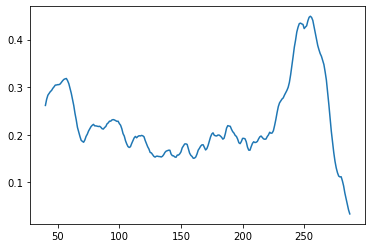

In [114]:
sanitise = features_df.loc[
    idx["rwrist", 0, "sanitise", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[40:40+248]

print(sanitise.shape)

sanitise.plot()

<BarContainer object of 10 artists>

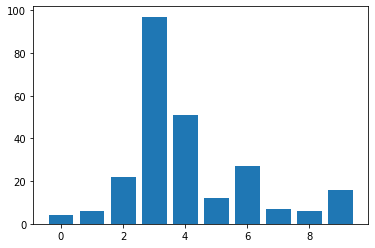

In [115]:
histo = np.histogram(features_df.loc[
    idx["rwrist", 0, "sanitise", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[40:40+248]/248,bins=10)
plt.bar(x=np.asarray(range(10)),height=histo[0])

(248,)


<AxesSubplot:>

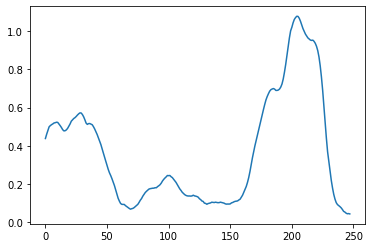

In [116]:
rubiks_cube = features_df.loc[
    idx["rwrist", 0, "rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)

print(rubiks_cube.shape)

rubiks_cube.plot()

<BarContainer object of 10 artists>

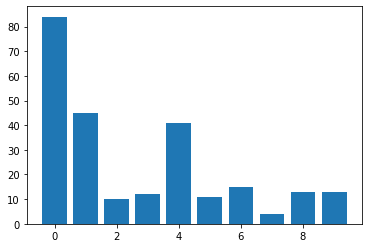

In [117]:
histo = np.histogram(features_df.loc[
    idx["rwrist", 0, "rubiks_cube", [0], :],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)/248,bins=10)
plt.bar(x=np.asarray(range(10)),height=histo[0])

# Analisi della distribuzione dell' accelerazione

(185,)


<AxesSubplot:>

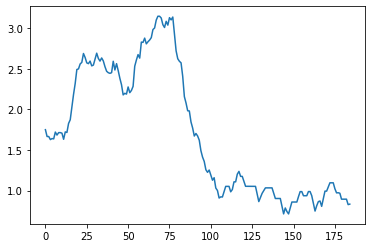

In [118]:
eat_crisp = features_df.loc[
    idx["rwrist", 0, "eat_crisp", [0], :],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:185]

print(eat_crisp.shape)

eat_crisp.plot()

<BarContainer object of 10 artists>

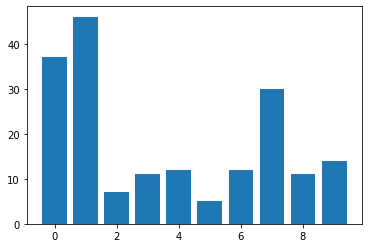

In [119]:
histo = np.histogram(features_df.loc[
    idx["rwrist", 0, "eat_crisp", [0], :],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:185]/185,bins=10)
plt.bar(x=np.asarray(range(10)),height=histo[0])

(185,)


<AxesSubplot:>

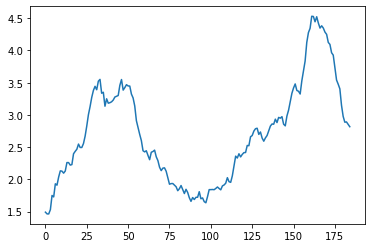

In [120]:
drinking = features_df.loc[
    idx["rwrist", 0, "drinking", [0], :],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)

print(drinking.shape)

drinking.plot()

<BarContainer object of 10 artists>

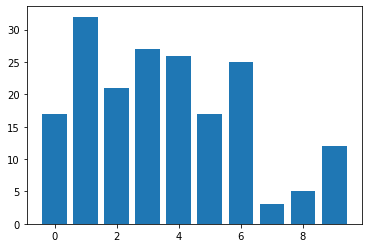

In [121]:
histo = np.histogram(features_df.loc[
    idx["rwrist", 0, "drinking", [0], :],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)/185,bins=10)
plt.bar(x=np.asarray(range(10)),height=histo[0])

# Spider web visualisation

In [122]:
import numpy as np
import matplotlib.pyplot as plt

"""
categories = ['Food Quality', 'Food Variety', 'Service Quality', 'Ambiance', 'Affordability']

restaurant_1 = [4, 4, 5, 4, 3]
restaurant_2 = [5, 5, 4, 5, 2]
restaurant_3 = [3, 4, 5, 3, 5]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(restaurant_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, restaurant_1, label='Restaurant 1')
plt.plot(label_loc, restaurant_2, label='Restaurant 2')
plt.plot(label_loc, restaurant_3, label='Restaurant 3')
plt.title('Restaurant comparison', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

"""

"\ncategories = ['Food Quality', 'Food Variety', 'Service Quality', 'Ambiance', 'Affordability']\n\nrestaurant_1 = [4, 4, 5, 4, 3]\nrestaurant_2 = [5, 5, 4, 5, 2]\nrestaurant_3 = [3, 4, 5, 3, 5]\n\nlabel_loc = np.linspace(start=0, stop=2 * np.pi, num=len(restaurant_1))\n\nplt.figure(figsize=(8, 8))\nplt.subplot(polar=True)\nplt.plot(label_loc, restaurant_1, label='Restaurant 1')\nplt.plot(label_loc, restaurant_2, label='Restaurant 2')\nplt.plot(label_loc, restaurant_3, label='Restaurant 3')\nplt.title('Restaurant comparison', size=20)\nlines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)\nplt.legend()\nplt.show()\n\n"

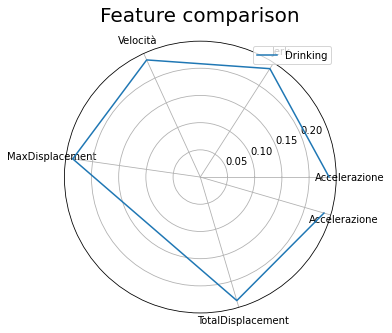

In [189]:
#categories = ['Food Quality', 'Food Variety', 'Service Quality', 'Ambiance', 'Affordability']
categories = ['Accelerazione', 'Jerk', 'Velocità', 'MaxDisplacement', 'TotalDisplacement']

"""
categories = [features_df.loc[idx["rwrist", :, ["drinking", "eat_crisp"], [0], :],idx["dynamic", "acceleration", "mean", "magnitude"]],
              features_df.loc[idx["rwrist", :, ["drinking", "eat_crisp"], [0], :],idx["dynamic", "velocities", "mean", "magnitude"]],
              features_df.loc[idx["rwrist", :, ["drinking", "eat_crisp"], [0], :],idx["dynamic", "jerk", "mean", "magnitude"]],
              features_df.loc[idx["rwrist", :, ["drinking", "eat_crisp"], [0], :],idx["displacement","positions", "total_displacement", "magnitude"]],
              features_df.loc[idx["rwrist", :, ["drinking", "eat_crisp"], [0], :],idx["displacement", "positions", "max_displacement",  "magnitude"]]
             ] 
"""

categories = [*categories, categories[0]]

joints = ['rwrist']
actions = ['drinking']

d1 = features_df.loc[idx[joints, :, actions, :],idx[['dynamic'], ['velocities'],  ["mean"], ["magnitude"]]]
d2 = features_df.loc[idx[joints, :, actions, :],idx[['dynamic'], ['acceleration'],  ["mean"], ["magnitude"]]]
d3 = features_df.loc[idx[joints, :, actions, :],idx[['dynamic'], ['jerk'],  ["mean"], ["magnitude"]]]
d4 = features_df.loc[idx[joints, :, actions, :],idx[['displacement'], ['position'],  ["total_displacement"], ["magnitude"]]]
d5 = features_df.loc[idx[joints, :, actions, :],idx[['displacement'], ['position'],  ["max_displacement"], ["magnitude"]]]

d1,a,b,c = my_train_test_slipt(X,["rwrist"], ["drinking"])
d2,a,b,c = my_train_test_slipt(X,["rwrist"], ["drinking"])
d3,a,b,c = my_train_test_slipt(X,["rwrist"], ["drinking"])
d4,a,b,c = my_train_test_slipt(X,["rwrist"], ["drinking"])
d5,a,b,c = my_train_test_slipt(X,["rwrist"], ["drinking"])


drinking = [d1, d2, d3, d4, d5]
drinking = [*drinking, drinking[0]]
            
eat_crisp = [
              features_df.loc[idx["rwrist", :, "eat_crisp", [0], :],idx["dynamic", "acceleration", "mean", "magnitude"]],
              features_df.loc[idx["rwrist", :, "eat_crisp", [0], :],idx["dynamic", "velocities", "mean", "magnitude"]],
              features_df.loc[idx["rwrist", :, "eat_crisp", [0], :],idx["dynamic", "jerk", "mean", "magnitude"]],
              features_df.loc[idx["rwrist", :, "eat_crisp", [0], :],idx["displacement","positions", "total_displacement", "magnitude"]],
              features_df.loc[idx["rwrist", :, "eat_crisp", [0], :],idx["displacement", "positions", "max_displacement",  "magnitude"]]
           ]


d1_bis = list()
for i in range (0,len(d1)):
    d1_bis.append(float(d1[i]))
    
d2_bis = list()
for i in range (0,len(d2)):
    d2_bis.append(float(d2[i]))
    
d3_bis = list()
for i in range (0,len(d3)):
    d3_bis.append(float(d3[i]))
    
d4_bis = list()
for i in range (0,len(d4)):
    d4_bis.append(float(d4[i]))

d5_bis = list()
for i in range (0,len(d5)):
    d5_bis.append(float(d5[i]))
    

drinking = [np.mean(d1_bis), np.mean(d2_bis), np.mean(d3_bis), np.mean(d4_bis), np.mean(d5_bis)]
drinking = [*drinking, drinking[0]]

eat_crisp = [*eat_crisp, eat_crisp[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(drinking))
label_loc = label_loc.astype(int)
label_loc = list(dict.fromkeys(label_loc))


plt.figure(figsize=(5, 5))
plt.subplot(polar=True)
plt.plot(label_loc, drinking, label='Drinking')
#plt.plot(label_loc, eat_crisp, label='Eat_crisp')
plt.title('Feature comparison', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

[0.         1.57079633 3.14159265 4.71238898 6.28318531]
[  0.  90. 180. 270. 360.]


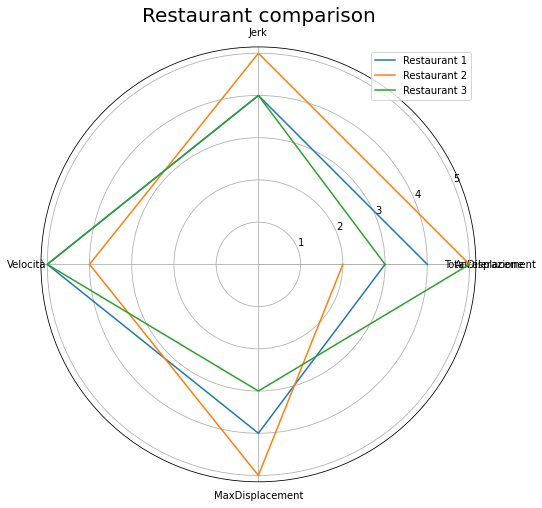

In [148]:
categories = ['Accelerazione', 'Jerk', 'Velocità', 'MaxDisplacement', 'TotalDisplacement']

restaurant_1 = [4, 4, 5, 4, 3]
restaurant_2 = [5, 5, 4, 5, 2]
restaurant_3 = [3, 4, 5, 3, 5]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(restaurant_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, restaurant_1, label='Restaurant 1')
plt.plot(label_loc, restaurant_2, label='Restaurant 2')
plt.plot(label_loc, restaurant_3, label='Restaurant 3')
plt.title('Restaurant comparison', size=20)
print(label_loc)
print(np.degrees(label_loc))
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

# Conclusioni

Rispetto all'analisi dei dati svolta, posso dire che la correlazione tra le varie azioni di trasporto è molto alta dal punto di vista della frequenza e vale la stessa cosa per la correlazione di trasporto e tocco del cubo di rubik.

Una scoperta interessante è data dal t-test in quanto risultano molto più simili tra loro le azioni di trasporto e tocco del cubo di rubik piutto che le varie azioni di trasporto, fatta eccezione per trasporto penna e trasporto cubo di rubik che hanno un p-value lievemente maggiore del livello di significatività.

Per quanto riguarda la classificazione con regressione logistica tra azioni di trasporto e tocco del cubo di rubik non si arriva a buoni risultati, ma questo potrebbe essere dovuto al fatto che risultino simili dal t-test. Mentre la regresssione logistica fatta per classificare le varie azioni di trasporto (bottiglia, tocco, cubo di rubik) da cui ci aspettavamo buoni risultati in quanto dal t-test queste azioni sono considerate distinte, da inspiegabilmente pessimi risultati, anche più deludenti rispetto alla precedente, infatti il regression score è minore del 50%.

Infine per quanto riguarda la clusterizzazione con kmeans riproponendo come cluster trasporto e tocco del cubo di rubik otteniamo che secondo l'indice di silhouette è corretto usare due cluster. Mentre la seconda clusterizzazione che divide in base alle persone, non da buoni risultati rispetto allo stesso indice.